In [ ]:
from google.colab import files
files.upload()

Saving kaggle_2.json to kaggle_2.json


{'kaggle_2.json': b'{"username":"bochrastudentmira","key":"e783d552707fe6e0dfb513a89aafff66"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle_2.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle_2.json

In [ ]:
!kaggle datasets download -d balraj98/massachusetts-buildings-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset
License(s): other
100% 1.49G/1.49G [00:15<00:00, 83.6MB/s]
100% 1.49G/1.49G [00:15<00:00, 105MB/s] 


In [ ]:
!unzip /content/massachusetts-buildings-dataset.zip -d /content/massachusetts-buildings-dataset

Archive:  /content/massachusetts-buildings-dataset.zip
  inflating: /content/massachusetts-buildings-dataset/label_class_dict.csv  
  inflating: /content/massachusetts-buildings-dataset/metadata.csv  
  inflating: /content/massachusetts-buildings-dataset/png/test/22828930_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/22828990_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/22829050_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/23429020_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/23429080_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/23578960_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/23579005_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/23729035_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/23879080_15.png  
  inflating: /content/massachusetts-buildings-dataset/png/test/2417906

In [ ]:
!pip install Pillow
!pip install tensorflow

## Some Usefull Functions

In [ ]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose, Flatten, Dense

In [ ]:
def sort_by_name(arr, split_at):
    return sorted([f for f in arr if f.split(split_at)[0].isdigit()], key=lambda x: int(x.split(split_at)[0]))

def load_data(image_dir, mask_dir, size=1, stratify=False):
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)
    images = []
    masks = []
    prefixes = []
    for img_file in image_files:
        if img_file.endswith('.png'):
            mask_file = img_file
            if mask_file in mask_files:
                images.append(img_file)
                masks.append(mask_file)
                if stratify:
                    prefixes.append(img_file.split('_')[0])
    sorted_images = sort_by_name(images, '_')
    sorted_masks = sort_by_name(masks, '_')
    assert len(sorted_images) == len(sorted_masks), "Number of images and masks should be the same."
    if stratify:
        sorted_images, _, sorted_masks, _ = train_test_split(
            sorted_images, sorted_masks, test_size=size, stratify=prefixes, random_state=42)
    else:
        sorted_images, _, sorted_masks, _ = train_test_split(
            sorted_images, sorted_masks, test_size=size, random_state=42)
    selected_images = [os.path.join(image_dir, img) for img in sorted_images]
    selected_masks = [os.path.join(mask_dir, mask) for mask in sorted_masks]
    return np.array(selected_images), np.array(selected_masks)

def load_image(file_path):
    return np.array(Image.open(file_path))

def display_data(image_paths, mask_paths):
    fig, axes = plt.subplots(5, 2, figsize=(12, 15))
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = load_image(image_path)
        mask = load_image(mask_path)
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')
    plt.show()

def random_augmentation(image, mask):
    data_gen_args = dict(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    seed = np.random.randint(0, 1000)
    img_augmented = image_datagen.random_transform(image, seed=seed)
    mask_augmented = mask_datagen.random_transform(mask, seed=seed)
    return img_augmented, mask_augmented

def preprocess_data(image_dir, mask_dir, sorted_images, sorted_masks, input_size, augmented=False):
    images = []
    masks = []
    for img_file, mask_file in zip(sorted_images, sorted_masks):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        img = load_img(img_path, target_size=input_size, color_mode='rgb')
        mask = load_img(mask_path, target_size=input_size, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        mask_array = img_to_array(mask, dtype=np.bool_)
        images.append(img_array)
        masks.append(mask_array)
        if augmented:
            aug_img, aug_mask = random_augmentation(img_array, mask_array)
            images.append(aug_img)
            masks.append(aug_mask)
    return np.array(images), np.array(masks)

## Using U-Net

 In this approach, I used a U-Net architecture with a VGG16 backbone where all the layers from the pre-trained VGG16 model were frozen. Freezing these layers means that the learned weights from ImageNet are preserved, and only the newly added decoder layers (used for segmentation) are trained. The learning rate was fixed at a relatively high value (e.g., 1e-4) to ensure the newly added layers learn effectively during the training process.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    """
    Here, all layers of VGG16 are frozen, meaning their weights won't be updated during training.
    This is useful when fine-tuning a pre-trained model to retain the general knowledge learned from
    the ImageNet dataset.

    """
    for layer in vgg16.layers:
        layer.trainable = False  # Initially freeze all layers


    """
    This block retrieves the outputs of the VGG16 convolutional layers. These layers correspond
    to the feature maps at different stages of the encoder (downsampling path). The Dropout layer is
    applied to the last block to prevent overfitting.

    """
    conv1 = vgg16.get_layer('block1_conv2').output
    conv2 = vgg16.get_layer('block2_conv2').output
    conv3 = vgg16.get_layer('block3_conv3').output
    conv4 = vgg16.get_layer('block4_conv3').output
    conv5 = vgg16.get_layer('block5_conv3').output
    conv5 = Dropout(0.3)(conv5)

    """
     the decoder keeps upsampling and concatenating with the corresponding encoder outputs,
     refining the features step by step.
    """
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=output)
    return model


In [ ]:
# Define the paths
image_dir = '/content/massachusetts-buildings-dataset/png/train/'
mask_dir = '/content/massachusetts-buildings-dataset/png/train_labels/'

# Check if directories exist
print("Image Directory Exists:", os.path.isdir(image_dir))
print("Mask Directory Exists:", os.path.isdir(mask_dir))

# List files in directories
if os.path.isdir(image_dir):
    print("Images Directory Files:", os.listdir(image_dir))
if os.path.isdir(mask_dir):
    print("Masks Directory Files:", os.listdir(mask_dir))

Image Directory Exists: True
Mask Directory Exists: True
Images Directory Files: ['22829005_15.png', '24029050_15.png', '23878930_15.png', '22978975_15.png', '23129140_15.png', '23128960_15.png', '23729095_15.png', '23429050_15.png', '23878990_15.png', '23428900_15.png', '23279095_15.png', '23429005_15.png', '24179020_15.png', '23279035_15.png', '23729080_15.png', '22829020_15.png', '23429095_15.png', '23428945_15.png', '24328855_15.png', '23428930_15.png', '23879050_15.png', '23729050_15.png', '24029080_15.png', '23878915_15.png', '23579095_15.png', '22829035_15.png', '23279170_15.png', '23578945_15.png', '22978900_15.png', '22679005_15.png', '22978960_15.png', '22828960_15.png', '22979050_15.png', '23579080_15.png', '23579020_15.png', '24478870_15.png', '24329020_15.png', '23128975_15.png', '23579110_15.png', '24179050_15.png', '23428990_15.png', '23728945_15.png', '23279020_15.png', '23129005_15.png', '24029065_15.png', '23129050_15.png', '23278930_15.png', '23879065_15.png', '23129

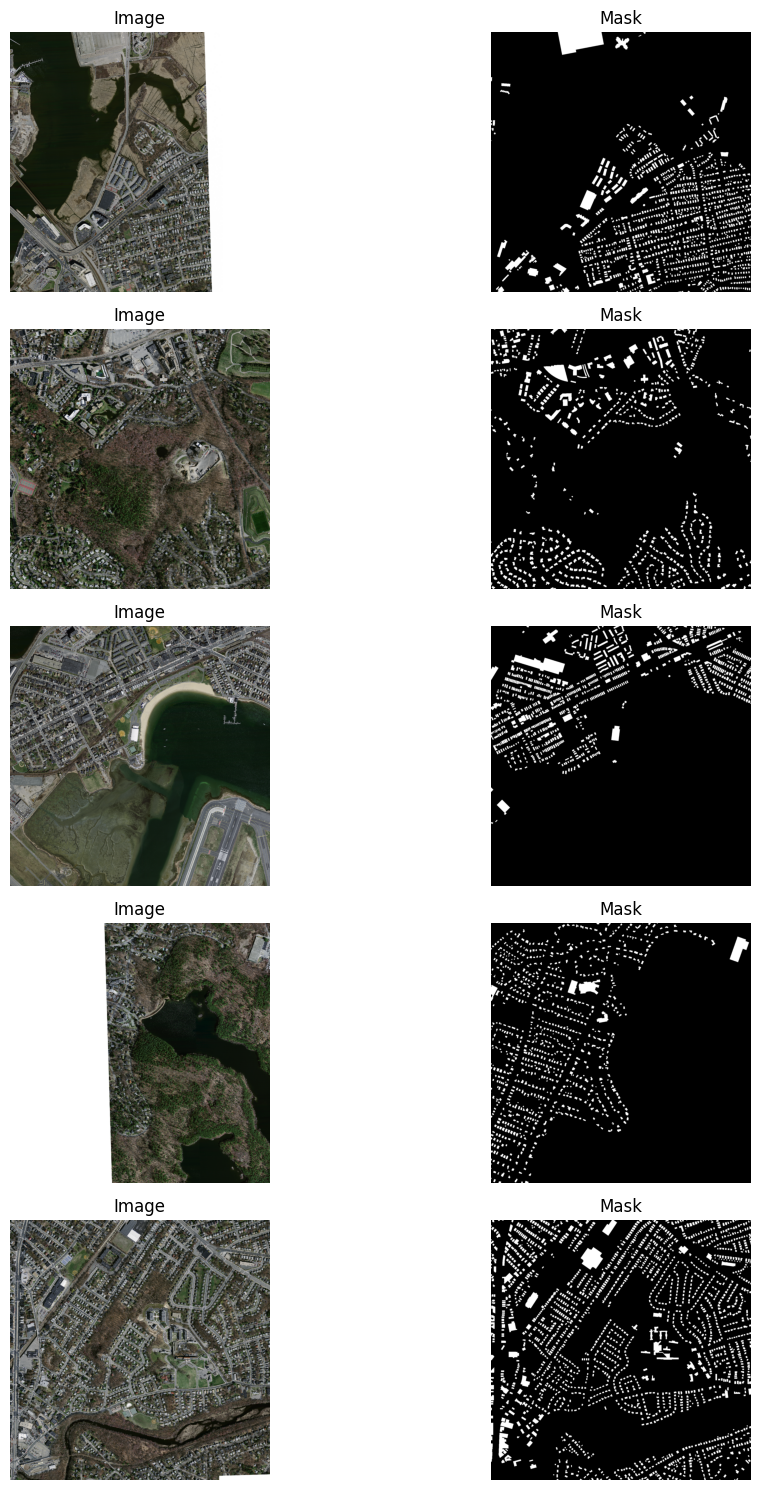

In [ ]:
selected_images, selected_masks = load_data(image_dir, mask_dir, size=1, stratify=False)
random_indices = random.sample(range(len(selected_images)), 5)
selected_image_paths = [selected_images[i] for i in random_indices]
selected_mask_paths = [selected_masks[i] for i in random_indices]
display_data(selected_image_paths, selected_mask_paths)

In [ ]:
with tf.device("/device:GPU:0"):
    images, masks = preprocess_data(image_dir, mask_dir, selected_images, selected_masks, input_size=(256, 256), augmented=True)

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42)


In [ ]:
model = unet_vgg16(input_shape=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])

history = model.fit(train_images, train_masks,
                    epochs=30,
                    batch_size=16,
                    validation_data=(val_images, val_masks))

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.5807 - loss: 0.8366 - val_accuracy: 0.7834 - val_loss: 0.7403
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - accuracy: 0.8082 - loss: 0.7456 - val_accuracy: 0.8587 - val_loss: 0.6903
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 489ms/step - accuracy: 0.8679 - loss: 0.6972 - val_accuracy: 0.8142 - val_loss: 0.6485
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.8596 - loss: 0.6613 - val_accuracy: 0.8427 - val_loss: 0.6287
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.8755 - loss: 0.6321 - val_accuracy: 0.8505 - val_loss: 0.6125
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 570ms/step - accuracy: 0.8793 - loss: 0.6250 - val_accuracy: 0.8634 - val_loss: 0.6004
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.8845 - loss: 0.6163 - val_accuracy: 0.8846 - val_loss: 0.6119
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 508ms/step - accuracy: 0.8851 - loss: 0.5950 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_masks)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model_path = '/content/unet_vgg16_model.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 20s/step - accuracy: 0.8984 - loss: 0.5698


Test Accuracy: 0.8944


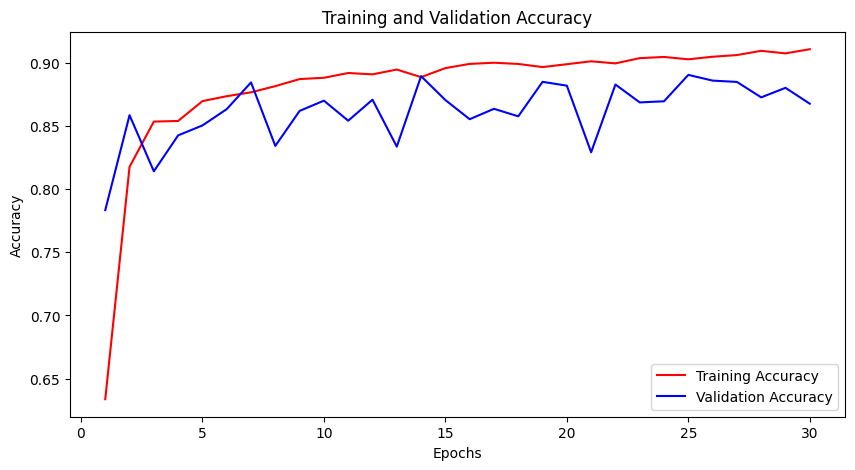

In [ ]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


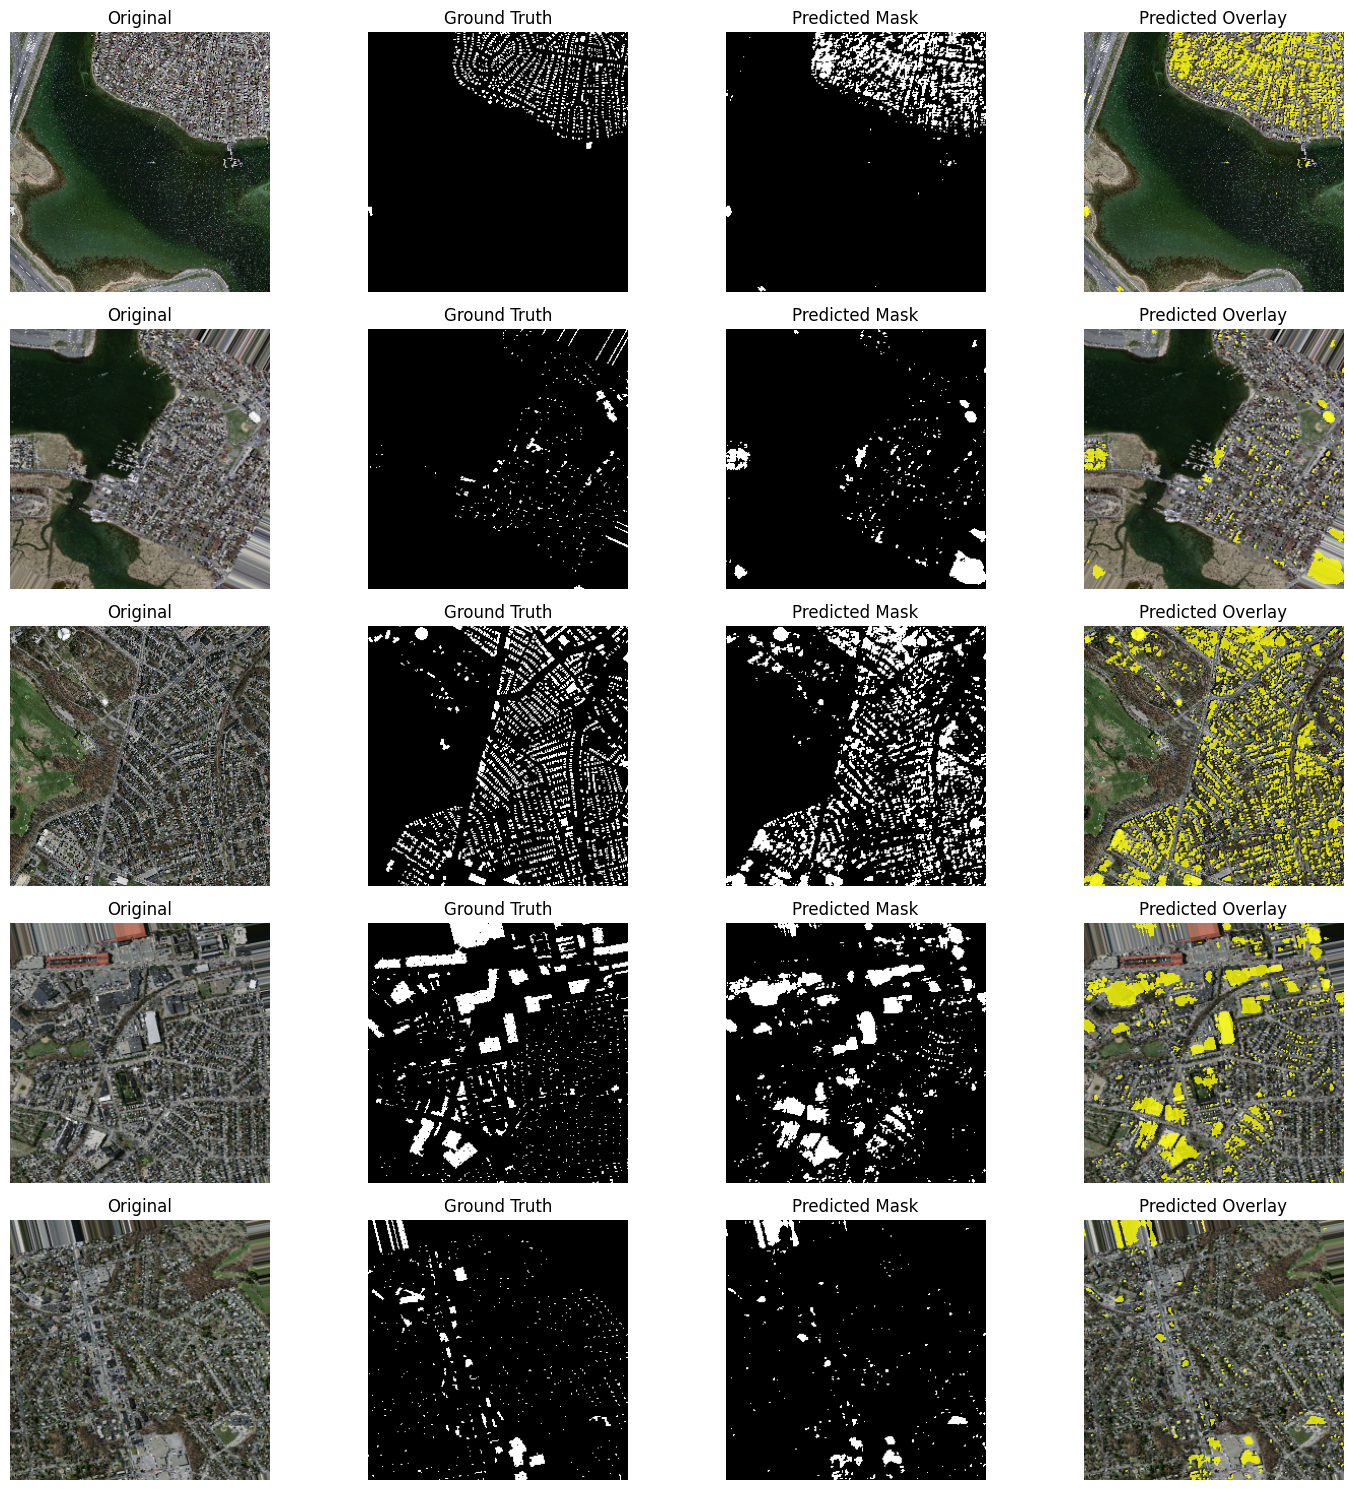

In [ ]:

# Display 5 random predictions
random_indices = random.sample(range(len(test_images)), 5)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)  # Binary predictions

fig, axes = plt.subplots(5, 4, figsize=(15, 15))

for i in range(len(test_sample)):
    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]

    # Create a grayscale mask
    grayscale_mask = np.zeros_like(image[:, :, 0])
    grayscale_mask[mask[:, :, 0] == 1] = 255

    # Apply the mask on the image
    result = image.copy()
    result[mask[:, :, 0] == 1] = [255, 255, 0]
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(image, alpha, result, 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    ground_truth = (test_masks[random_indices][i] * 255).astype(np.uint8)
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(grayscale_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('/content/result.png', bbox_inches='tight')

# Show the plot
plt.show()


 ## U-Net with Unfreezing Last Layers

To enhance the model’s performance further, I unfroze the layers from the last block of VGG16, enabling these layers to be trained along with the new layers. This fine-tuning step allows the model to adapt the pre-trained features to the specific task of semantic segmentation by gradually adjusting the weights of these layers with a lower learning rate.

In [ ]:
# Define dice loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Define U-Net with VGG16 backbone
def unet_vgg16(input_shape):
    inputs = Input(input_shape)

    # Excluding the classification layers
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    """
    Here, all layers of VGG16 are frozen, meaning their weights won't be updated during training.
    This is useful when fine-tuning a pre-trained model to retain the general knowledge learned from
    the ImageNet dataset.

    """
    for layer in vgg16.layers:
        layer.trainable = False  # Initially freeze all layers


    """
    This block retrieves the outputs of the VGG16 convolutional layers. These layers correspond
    to the feature maps at different stages of the encoder (downsampling path). The Dropout layer is
    applied to the last block to prevent overfitting.

    """
    conv1 = vgg16.get_layer('block1_conv2').output
    conv2 = vgg16.get_layer('block2_conv2').output
    conv3 = vgg16.get_layer('block3_conv3').output
    conv4 = vgg16.get_layer('block4_conv3').output
    conv5 = vgg16.get_layer('block5_conv3').output
    conv5 = Dropout(0.3)(conv5)


    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=output)
    return model

# Create and compile the model
input_shape = (256, 256, 3)
model = unet_vgg16(input_shape)
optimizer = Adam(learning_rate=1e-4)  # Initial learning rate
model.compile(optimizer=optimizer, loss=dice_loss, metrics=['accuracy'])


In [ ]:

# # Define a learning rate schedule
# def lr_schedule(epoch, lr):
#     initial_lr = 1e-5
#     decay = 0.9
#     if epoch > 0:
#         lr = initial_lr * (decay ** (epoch // 5))  # Decay every 5 epochs
#     return lr

# # Create a LearningRateScheduler callback
# lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# # Unfreeze some layers
# for layer in model.layers:
#     if 'block5' in layer.name:  # Unfreeze layers from the last block of VGG16
#         layer.trainable = True

# # Recompile the model after unfreezing layers
# optimizer = Adam(learning_rate=1e-5)  # Use a lower learning rate for fine-tuning
# model.compile(optimizer=optimizer, loss=dice_loss, metrics=['accuracy'])

# # Continue training
# history_finetune = model.fit(train_images, train_masks,
#                              epochs=20,  # Additional epochs for fine-tuning
#                              batch_size=16,
#                              validation_data=(val_images, val_masks),
#                              callbacks=[lr_scheduler])


# Unfreeze some layers
for layer in model.layers:
    if 'block5' in layer.name:  # Unfreeze layers from the last block of VGG16
        layer.trainable = True

# Recompile the model after unfreezing layers
optimizer = Adam(learning_rate=1e-5)  # Fixed learning rate for fine-tuning
model.compile(optimizer=optimizer, loss=dice_loss, metrics=['accuracy'])

# Continue training
history_finetune = model.fit(train_images, train_masks,
                             epochs=20,
                             batch_size=16,
                             validation_data=(val_images, val_masks))


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3113 - loss: 0.8422 - val_accuracy: 0.2855 - val_loss: 0.8048
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 572ms/step - accuracy: 0.3149 - loss: 0.8361 - val_accuracy: 0.3572 - val_loss: 0.7982
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 515ms/step - accuracy: 0.4060 - loss: 0.8280 - val_accuracy: 0.5167 - val_loss: 0.7885
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - accuracy: 0.5525 - loss: 0.8239 - val_accuracy: 0.6861 - val_loss: 0.7757
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - accuracy: 0.7046 - loss: 0.8020 - val_accuracy: 0.7684 - val_loss: 0.7638
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 522ms/step - accuracy: 0.7594 - loss: 0.7760 - val_accuracy: 0.7761 - val_loss: 0.7500
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.7750 - loss: 0.7670 - val_accuracy: 0.8038 - val_loss: 0.7385
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - accuracy: 0.8150 - loss: 0.7579 - val_accuracy: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8875 - loss: 0.6622


Test Accuracy: 0.8819
Model saved to /content/unet_vgg16_model_finetuned_2.h5


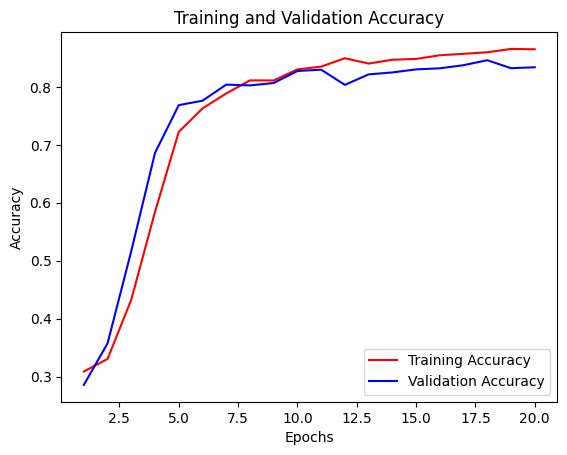

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


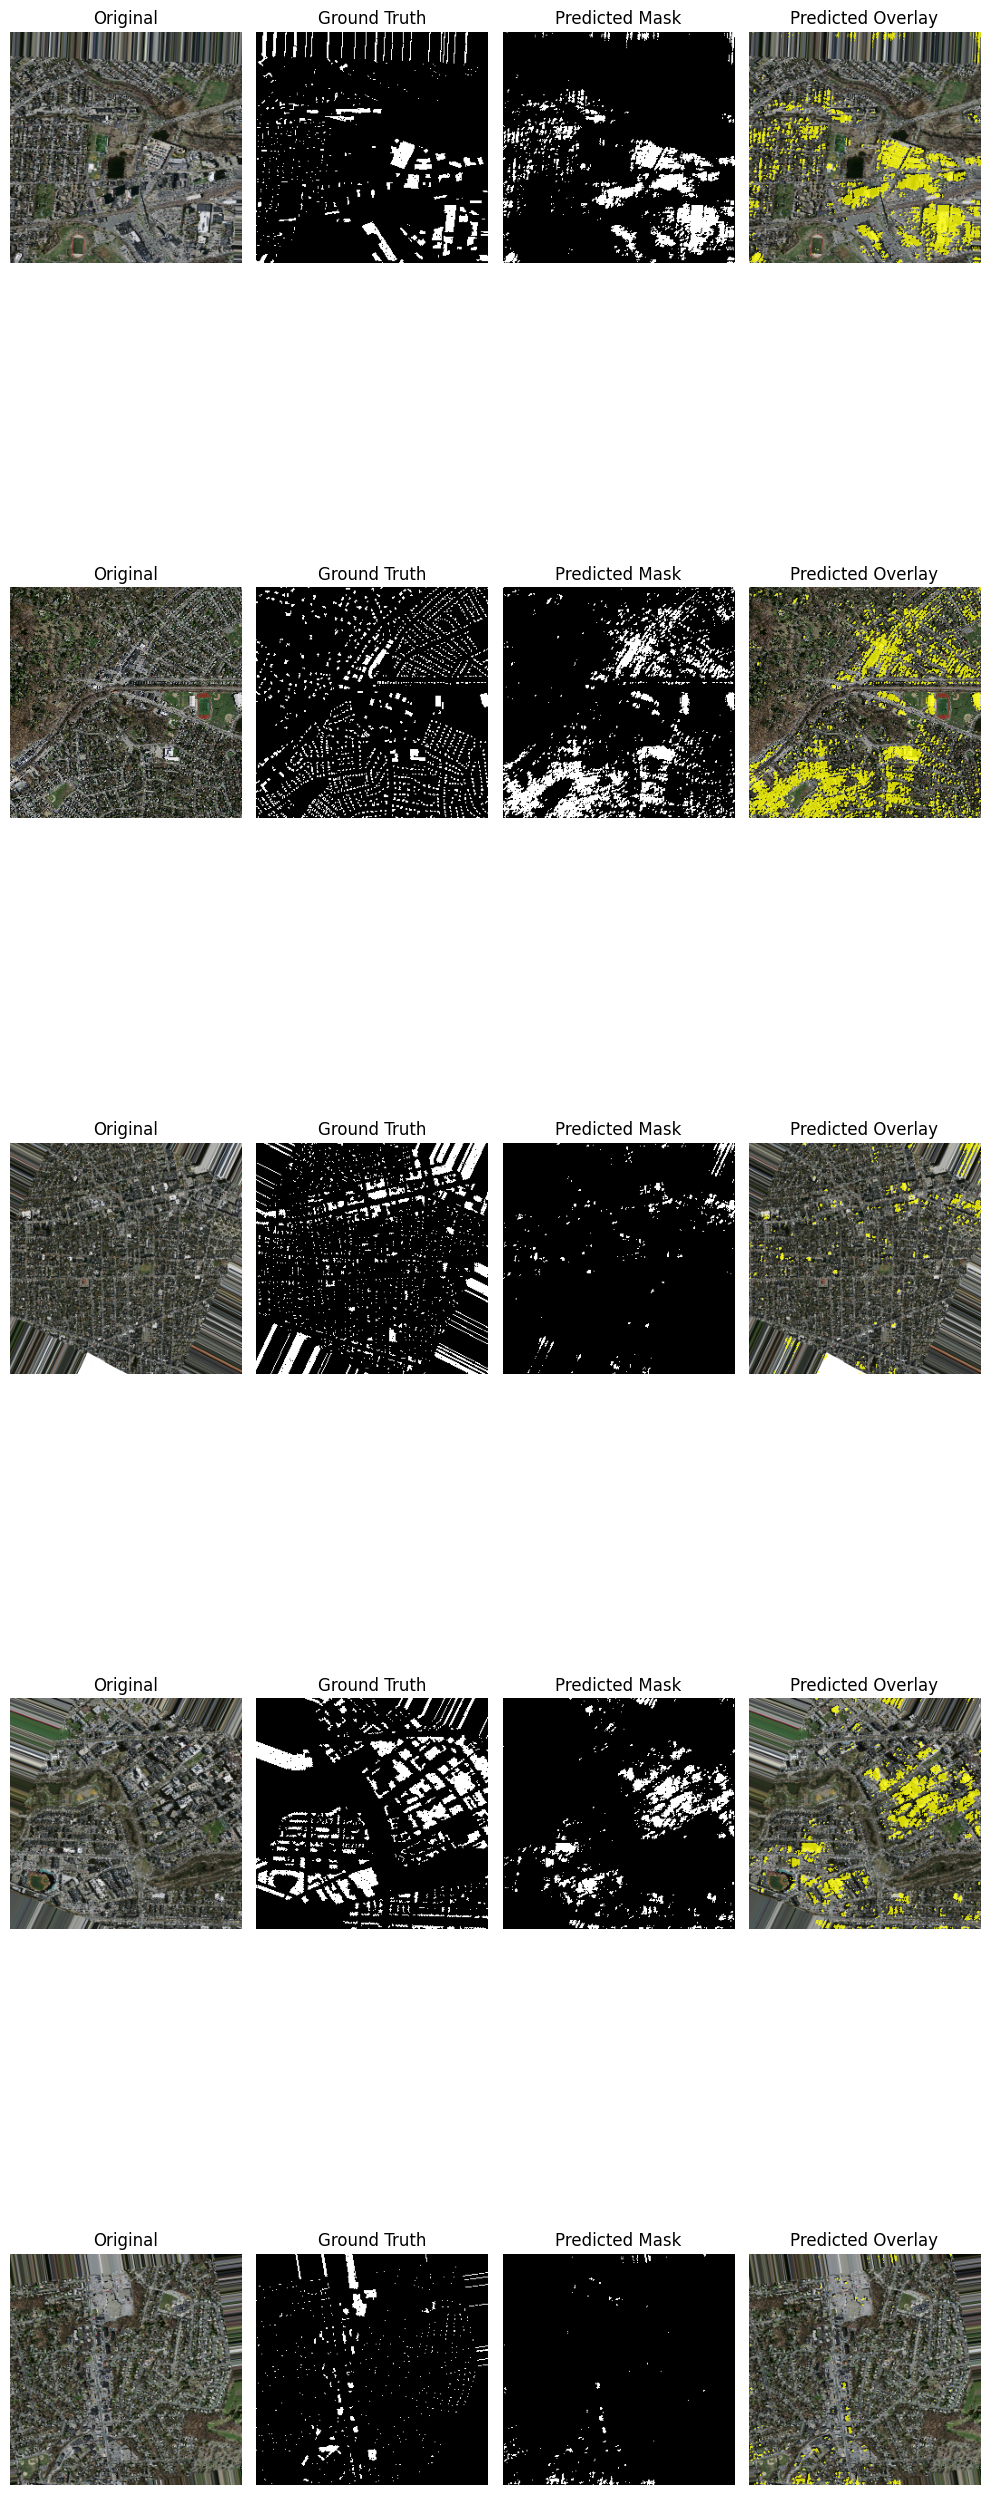

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_masks)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the model
model_path = '/content/unet_vgg16_model_finetuned_2.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

# Access training and testing accuracy
train_accuracy = history_finetune.history['accuracy']
val_accuracy = history_finetune.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Display 5 random predictions
random_indices = random.sample(range(len(test_images)), 5)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(5, 4, figsize=(10, 3*10))

for i in range(len(test_sample)):
    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]

    # Create a grayscale mask
    grayscale_mask = np.zeros_like(image[:, :, 0])
    grayscale_mask[mask[:, :, 0] == 1] = 255

    # Apply the mask on the image
    result = image.copy()
    result[mask[:, :, 0] == 1] = [255, 255, 0]
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(image, alpha, result, 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255])
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(grayscale_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('/content/result.png', bbox_inches='tight')

# Show the plot
plt.show()


## Using SegNet Model

In this approach, I used a Seg-Net architecture with a VGG16 backbone where all the layers from the pre-trained VGG16 model were frozen.

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.0909 - loss: 0.8504 - val_accuracy: 0.1058 - val_loss: 0.8086
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.1192 - loss: 0.8373 - val_accuracy: 0.3861 - val_loss: 0.7957
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.5163 - loss: 0.8138 - val_accuracy: 0.4911 - val_loss: 0.7733
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.6518 - loss: 0.7570 - val_accuracy: 0.5574 - val_loss: 0.7700
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.6712 - loss: 0.7677 - val_accuracy: 0.6119 - val_loss: 0.7693
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.7593 - loss: 0.7573 - val_accuracy: 0.6064 - val_loss: 0.7664
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.7266 - loss: 0.7462 - val_accuracy: 0.7074 - val_loss: 0.7659
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.7831 - loss: 0.7396 - val_accuracy: 0.6

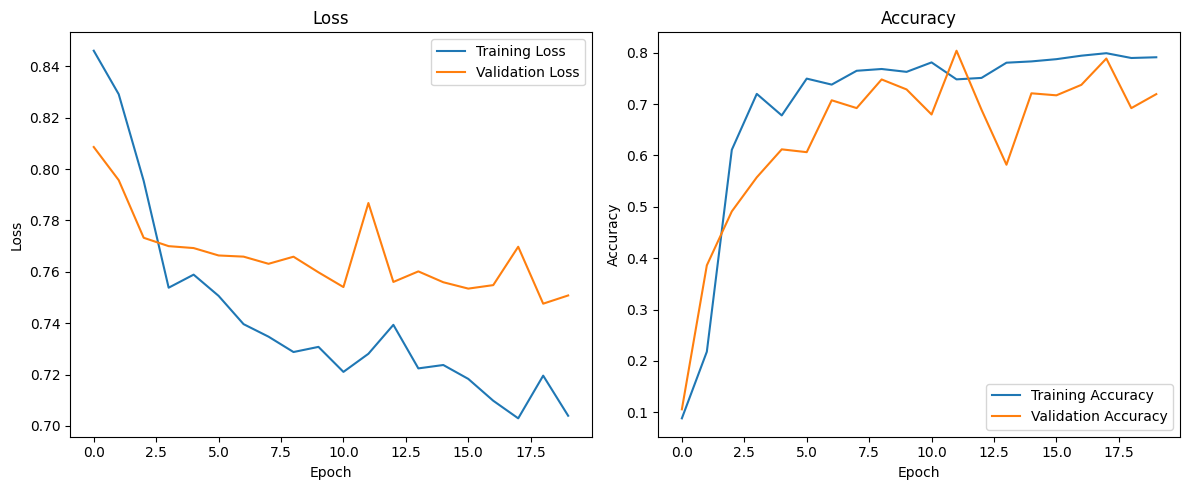

2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 21s/step


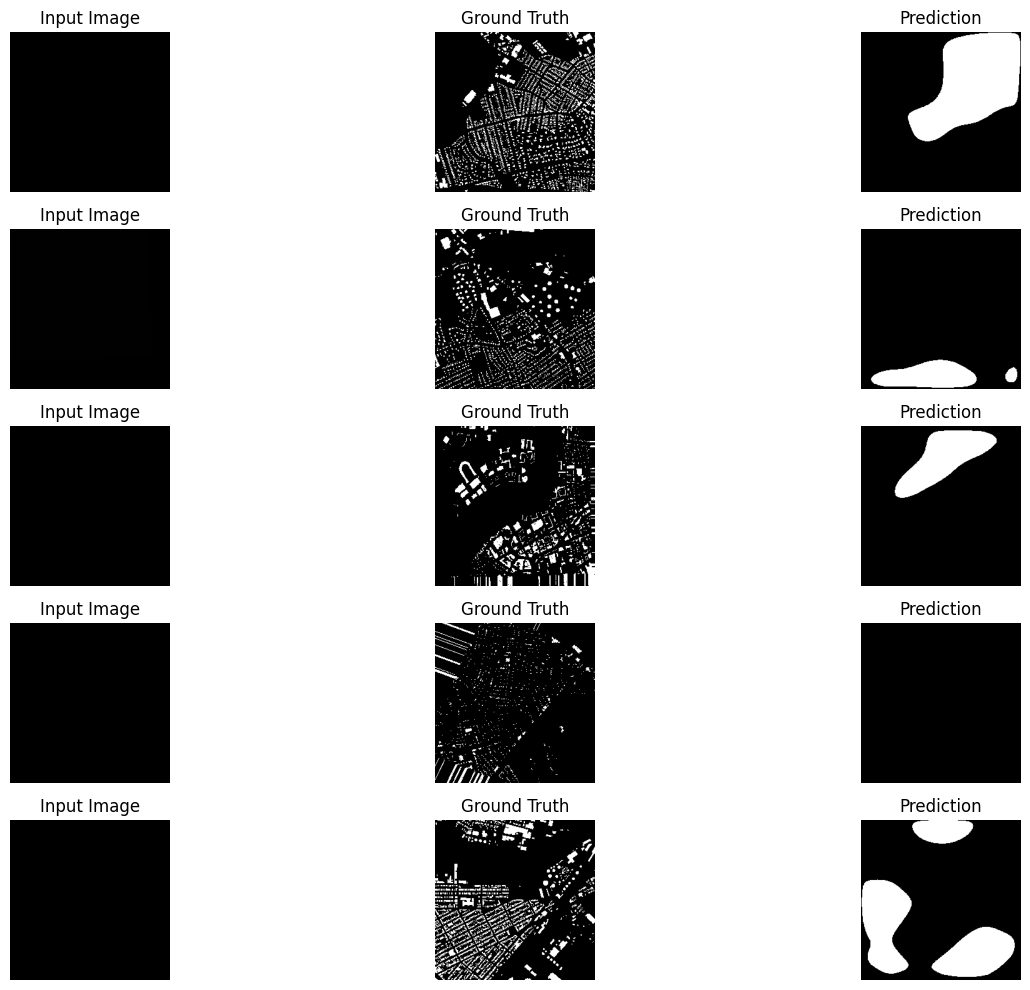

In [ ]:
# Define dice loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Define the SegNet model with VGG16 encoder
def segnet_vgg16(input_shape):
    inputs = Input(input_shape)

    # Encoder using VGG16
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in vgg16.layers:
        layer.trainable = False  # Freeze all layers of VGG16

    # Encoder blocks (from VGG16)
    conv1 = vgg16.get_layer('block1_conv2').output
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = vgg16.get_layer('block2_conv2').output
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = vgg16.get_layer('block3_conv3').output
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = vgg16.get_layer('block4_conv3').output
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = vgg16.get_layer('block5_conv3').output
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    # Decoder blocks (upsampling and convolution)
    up6 = UpSampling2D(size=(2, 2))(pool5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)

    # Output layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    # Build the model
    model = Model(inputs=inputs, outputs=output)
    return model

# Create and compile the SegNet model
input_shape = (256, 256, 3)
model = segnet_vgg16(input_shape)
optimizer = Adam(learning_rate=1e-4)  # Fixed learning rate
model.compile(optimizer=optimizer, loss=dice_loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_masks,
                    epochs=20,
                    batch_size=16,
                    validation_data=(val_images, val_masks))

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions on test dataset
predictions = model.predict(val_images)

# Plot some predictions
num_examples = 5  # Number of examples to plot
plt.figure(figsize=(15, 10))
for i in range(num_examples):
    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.title("Input Image")
    plt.imshow(val_images[i].astype(np.uint8))
    plt.axis('off')

    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.title("Ground Truth")
    plt.imshow(val_masks[i].astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.title("Prediction")
    plt.imshow(predictions[i].astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
